In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.0 MB/s eta 0:00:00


In [2]:
import math
import numpy
import pandas
import matplotlib.pyplot as plot
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
APPL = pandas.read_csv("/content/drive/MyDrive/Datasets/preprocessed_AAPL")
TESL = pandas.read_csv("/content/drive/MyDrive/Datasets/preprocessed_TSLA")
GOOG = pandas.read_csv("/content/drive/MyDrive/Datasets/preprocessed_GOOG")

A widely used statistical test is the Dickey-Fuller test. It can be used to ascertain whether the series has a unit root and to ascertain whether it is stationary.

**Null Hypothesis**: There is a unit root in the series.

**Another Hypothesis**: There isn't a unit root in the series.

The series is non-stationary if the Null Hypothesis is not rejected.

In [4]:
def dickey_fuller_test(series):
  output = adfuller(series['Adj Close'], autolag = 'AIC')
  print("Output of Dickey Fuller Test")
  print(f'Test Statistics: {output[0]}')
  print(f'p-value: {output[1]}')
  print(f'Number of lags used: {output[2]}')
  print(f'Number of observations used: {output[3]}')
  for key, value in output[4].items():
    print(f'critical value ({key}): {value}')

# Apple

In [5]:
APPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.059303,115127600.0
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.029022,84472400.0
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.166470,88774400.0
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.469332,127007600.0
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,27.720936,134247600.0


In [6]:
APPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1704 non-null   object 
 1   Open       1704 non-null   float64
 2   High       1704 non-null   float64
 3   Low        1704 non-null   float64
 4   Close      1704 non-null   float64
 5   Adj Close  1704 non-null   float64
 6   Volume     1704 non-null   float64
dtypes: float64(6), object(1)
memory usage: 93.3+ KB


In [7]:
# Change datatype of Date column
APPL["Date"] = pandas.to_datetime(APPL["Date"])

In [8]:
dickey_fuller_test(APPL)

Output of Dickey Fuller Test
Test Statistics: -0.5102493513290421
p-value: 0.8900008377025831
Number of lags used: 18
Number of observations used: 1685
critical value (1%): -3.4342368189880146
critical value (5%): -2.8632568111941152
critical value (10%): -2.5676839863871304


The test statistic of -0.5102 is greater than the critical values at the 1%, 5%, and 10% significance levels.

Also, the p-value is greater than 0.05, this suggests that we fail to reject the null hypothesis. Consequently, it is necessary to employ the "Integrated (I)" concept, represented by the 'd' value in time series, to achieve stationarity in the data when constructing the Auto ARIMA model.

To reduce the values' magnitude and the series' upward trend, let's now take the log of the "Adj Close" column.

Text(0.5, 1.0, 'Standard Deviation & Rolling Mean of APPLE')

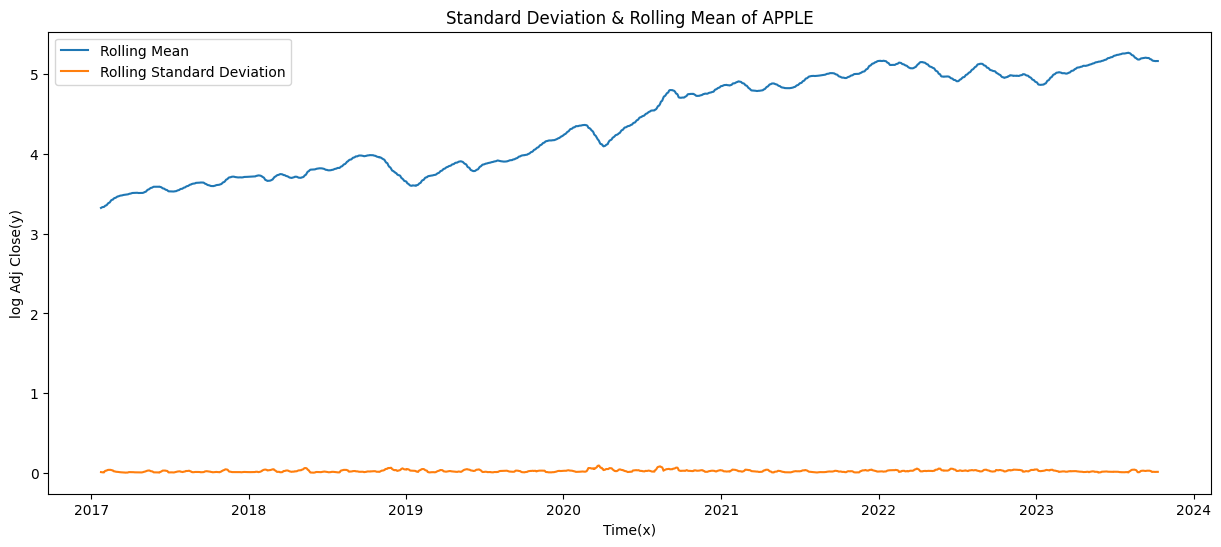

In [9]:
APPL['log Adj Close'] = numpy.log(APPL['Adj Close'])
log_avg_moving_APPL = APPL['log Adj Close'].rolling(15).mean()
std_log_APPL = APPL['log Adj Close'].rolling(15).std()

plot.figure(figsize = (15, 6))
plot.plot(APPL['Date'], log_avg_moving_APPL, label = "Rolling Mean")
plot.plot(APPL['Date'], std_log_APPL, label = "Rolling Standard Deviation")
plot.xlabel('Time(x)')
plot.ylabel('log Adj Close(y)')
plot.legend(loc = 'best')
plot.title("Standard Deviation & Rolling Mean of APPLE")

###Divide the data into training and test set

    Training Period: 2017-01-01 - 2023-06-30

    Testing Period:  2023-07-01 - 2023-10-10

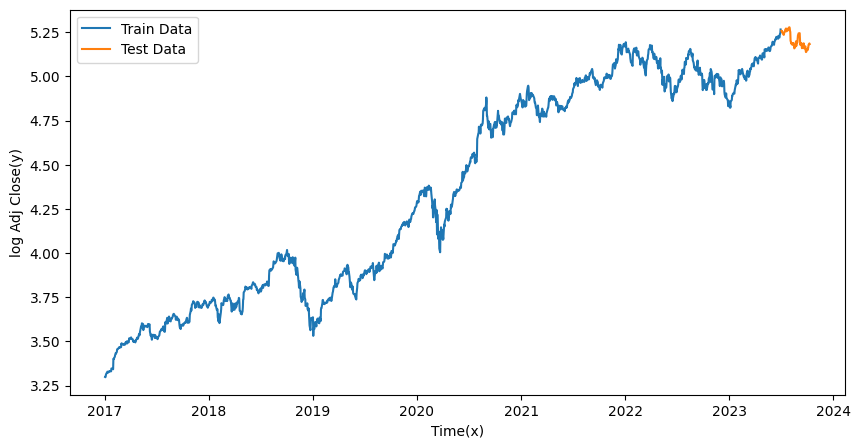

In [10]:
train_APPL_data = APPL[APPL['Date'] < '2023-07-01']
test_APPL_data = APPL[APPL['Date'] >= '2023-07-01'].reset_index(drop = True)

plot.figure(figsize = (10, 5))
plot.plot(train_APPL_data['Date'], train_APPL_data['log Adj Close'], label = 'Train Data')
plot.plot(test_APPL_data['Date'], test_APPL_data['log Adj Close'], label = 'Test Data')
plot.xlabel('Time(x)')
plot.ylabel('log Adj Close(y)')
plot.legend(loc = 'best')

###Modeling

In [11]:
auto_arima_model_APPL = auto_arima(train_APPL_data['log Adj Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(auto_arima_model_APPL.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1634
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4130.724
Date:                Mon, 11 Dec 2023   AIC                          -8255.448
Time:                        18:55:01   BIC                          -8239.253
Sample:                             0   HQIC                         -8249.441
                               - 1634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      2.742      0.006       0.000       0.002
ma.L1         -0.1023      0.016     -6.279      0.000      -0.134      -0.070
sigma2         0.0004   7.48e-06     49.720      0.0

In [12]:

arima_model_APPL = ARIMA(train_APPL_data['log Adj Close'], order = (5, 1, 1))
arima_model_fit_APPL = arima_model_APPL.fit()
print(arima_model_fit_APPL.summary())

                               SARIMAX Results                                
Dep. Variable:          log Adj Close   No. Observations:                 1634
Model:                 ARIMA(5, 1, 1)   Log Likelihood                4129.342
Date:                Mon, 11 Dec 2023   AIC                          -8244.684
Time:                        18:55:02   BIC                          -8206.896
Sample:                             0   HQIC                         -8230.666
                               - 1634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0490      0.313     -0.156      0.876      -0.663       0.565
ar.L2          0.0013      0.030      0.042      0.966      -0.058       0.061
ar.L3         -0.0125      0.019     -0.650      0.5

###Forecasting the closing stock value of Apple

1634    193.188503
1635    193.381407
1636    193.385601
1637    193.431642
1638    193.670304
           ...    
1699    193.655456
1700    193.655456
1701    193.655456
1702    193.655456
1703    193.655456
Name: predicted_mean, Length: 70, dtype: float64


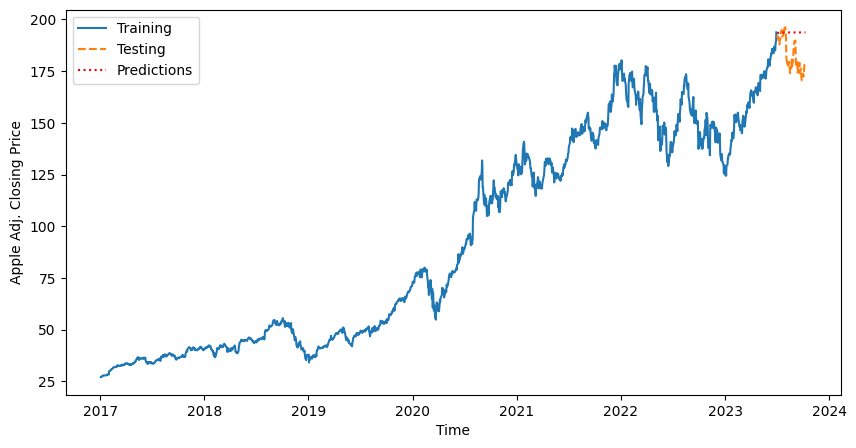

In [43]:
from collections import defaultdict
APPL_output=arima_model_fit_APPL.forecast(70, alpha=0.05)
APPL_predictions = numpy.exp(APPL_output)
# print(APPL_predictions)
plot.figure(figsize=(10, 5))
plot.plot(train_APPL_data['Date'], train_APPL_data['Adj Close'], label = 'Training')
plot.plot(test_APPL_data['Date'], test_APPL_data['Adj Close'], label = 'Testing', linestyle='--')
plot.plot(test_APPL_data['Date'],APPL_predictions, color='r', label='Predictions', linestyle=':')
plot.xlabel('Time')
plot.ylabel('Apple Adj. Closing Price')
plot.legend()
APPL_predictions = numpy.exp(APPL_output.mean())
# APPL_output=arima_model_fit_APPL.forecast(70, alpha=0.05)
# APPL_predictions = numpy.exp(APPL_output)
# print(APPL_predictions.shape)
# plot.figure(figsize=(10, 5))
# plot.plot(train_APPL_data['Date'], train_APPL_data['Adj Close'], label='Training', color='blue')
# plot.plot(test_APPL_data['Date'], test_APPL_data['Adj Close'], label='Testing', color='green')
# prediction_dates = pandas.date_range(start=test_APPL_data['Date'].iloc[0], periods=len(APPL_predictions))
# plot.plot(prediction_dates, APPL_predictions, label = 'Predictions', color='red')

# plot.xlabel('Time(x)')
# plot.ylabel('Closing Price(y)')
# plot.legend()

In [14]:
rmse = math.sqrt(mean_squared_error(test_APPL_data['Adj Close'], [APPL_predictions] * len(test_APPL_data)))
mape = numpy.mean(numpy.abs(APPL_predictions - test_APPL_data['Adj Close'])/numpy.abs(test_APPL_data['Adj Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 13.605805147923963
MAPE: 0.0640866640263021


#Tesla

In [15]:
TESL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500.0
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500.0
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500.0
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500.0
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500.0


In [16]:
TESL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1704 non-null   object 
 1   Open       1704 non-null   float64
 2   High       1704 non-null   float64
 3   Low        1704 non-null   float64
 4   Close      1704 non-null   float64
 5   Adj Close  1704 non-null   float64
 6   Volume     1704 non-null   float64
dtypes: float64(6), object(1)
memory usage: 93.3+ KB


In [17]:
dickey_fuller_test(TESL)

Output of Dickey Fuller Test
Test Statistics: -1.1879112712753916
p-value: 0.6787742398861485
Number of lags used: 24
Number of observations used: 1679
critical value (1%): -3.4342507300744147
critical value (5%): -2.863262951722777
critical value (10%): -2.5676872561165305


The test statistic of -1.1879 is greater than the critical values at the 1%, 5%, and 10% significance levels.

Also, the p-value is greater than 0.05, this suggests that we fail to reject the null hypothesis. Consequently, it is necessary to employ the "Integrated (I)" concept, represented by the 'd' value in time series, to achieve stationarity in the data when constructing the Auto ARIMA model.

To reduce the values' magnitude and the series' upward trend, let's now take the log of the "Adj Close" column.

Text(0.5, 1.0, 'Standard Deviation & Rolling Mean of TESLA')

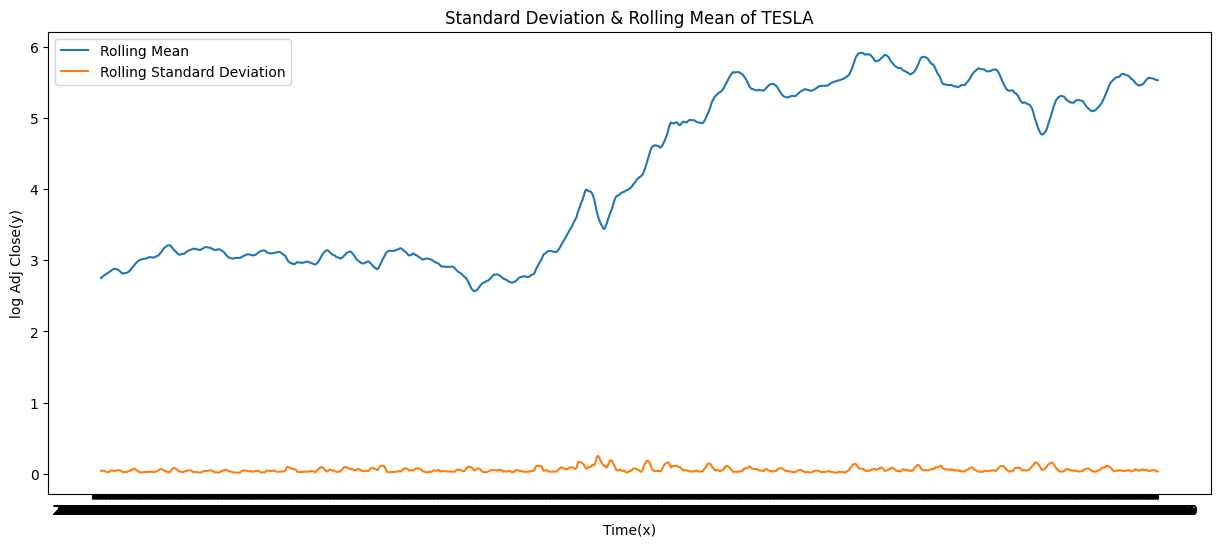

In [18]:
TESL['log Adj Close'] = numpy.log(TESL['Adj Close'])
log_avg_moving_TESL = TESL['log Adj Close'].rolling(15).mean()
std_log_TESL = TESL['log Adj Close'].rolling(15).std()

plot.figure(figsize = (15, 6))
plot.plot(TESL['Date'], log_avg_moving_TESL, label = "Rolling Mean")
plot.plot(TESL['Date'], std_log_TESL, label = "Rolling Standard Deviation")
plot.xlabel('Time(x)')
plot.ylabel('log Adj Close(y)')
plot.legend(loc = 'best')
plot.title("Standard Deviation & Rolling Mean of TESLA")

###Divide the data into training and test set

    Training Period: 2017-01-01 - 2023-06-30


---


    Testing Period:  2023-07-01 - 2023-10-10

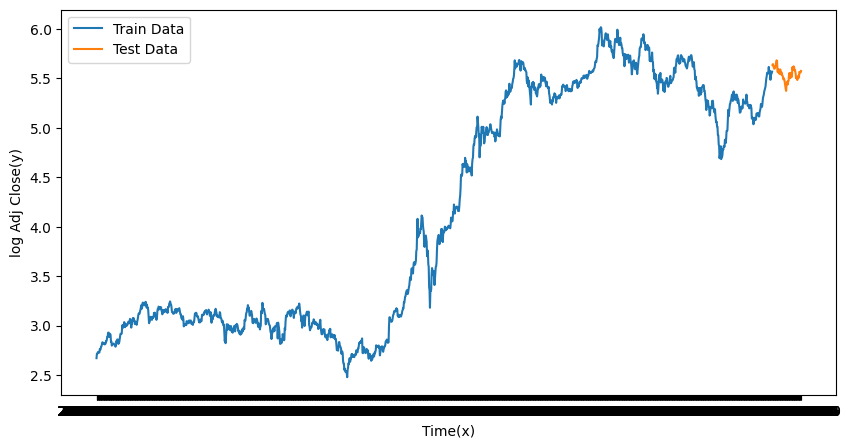

In [19]:
train_TESL_data = TESL[TESL['Date'] < '2023-07-01']
test_TESL_data = TESL[TESL['Date'] >= '2023-07-01'].reset_index(drop = True)

plot.figure(figsize = (10, 5))
plot.plot(train_TESL_data['Date'], train_TESL_data['log Adj Close'], label = 'Train Data')
plot.plot(test_TESL_data['Date'], test_TESL_data['log Adj Close'], label = 'Test Data')
plot.xlabel('Time')
plot.ylabel('Tesla Adj. Closing price')
plot.legend(loc = 'best')

###Modeling

In [20]:
auto_arima_model_TESL = auto_arima(train_TESL_data['log Adj Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(auto_arima_model_TESL.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1634
Model:               SARIMAX(2, 1, 2)   Log Likelihood                3002.864
Date:                Mon, 11 Dec 2023   AIC                          -5993.728
Time:                        18:56:12   BIC                          -5961.339
Sample:                             0   HQIC                         -5981.713
                               - 1634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.001      1.822      0.068      -0.000       0.005
ar.L1          0.6384      0.051     12.430      0.000       0.538       0.739
ar.L2         -0.8773      0.049    -17.964      0.0

In [21]:

arima_model_TESL = sm.tsa.arima.ARIMA(train_TESL_data['log Adj Close'], order = (5, 2, 1))
arima_model_fit_TESL = arima_model_TESL.fit()
print(arima_model_fit_TESL.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          log Adj Close   No. Observations:                 1634
Model:                 ARIMA(5, 2, 1)   Log Likelihood                2994.169
Date:                Mon, 11 Dec 2023   AIC                          -5974.337
Time:                        18:56:18   BIC                          -5936.554
Sample:                             0   HQIC                         -5960.321
                               - 1634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0224      0.020     -1.113      0.266      -0.062       0.017
ar.L2          0.0416      0.018      2.280      0.023       0.006       0.077
ar.L3          0.0343      0.020      1.714      0.0

###Forecasting the closing stock value of Tesla

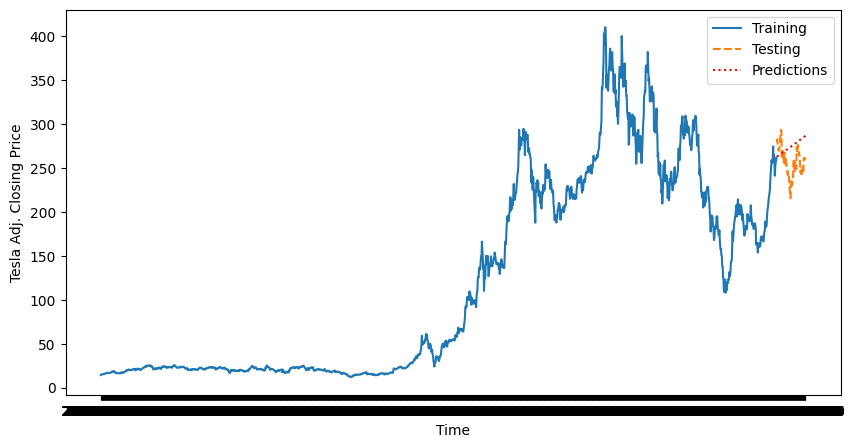

In [46]:

TESL_output=arima_model_fit_TESL.forecast(70, alpha=0.05)
# print("Tesla output: ",TESL_output.shape)
TESL_predictions = numpy.exp(TESL_output)

plot.figure(figsize=(10, 5))
plot.plot(train_TESL_data['Date'], train_TESL_data['Adj Close'], label='Training')
plot.plot(test_TESL_data['Date'], test_TESL_data['Adj Close'], label='Testing', linestyle='--')

plot.plot(test_TESL_data['Date'], TESL_predictions, label='Predictions', color='r', linestyle=':')


plot.xlabel('Time')
plot.ylabel('Tesla Adj. Closing Price')
plot.legend()
TESL_predictions = numpy.exp(TESL_output.mean())

In [23]:
rmse = math.sqrt(mean_squared_error(test_TESL_data['Adj Close'], [TESL_predictions] * len(test_TESL_data)))
mape = numpy.mean(numpy.abs(APPL_predictions - test_TESL_data['Adj Close'])/numpy.abs(test_TESL_data['Adj Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 23.982343673521456
MAPE: 0.24321904943123215


#Google

In [24]:
GOOG.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,38.940498,39.481499,38.790001,39.306999,39.306999,33146000.0
1,2017-01-04,39.417999,39.567001,39.158001,39.345001,39.345001,21460000.0
2,2017-01-05,39.304001,39.723999,39.250999,39.701000,39.701000,26704000.0
3,2017-01-06,39.763000,40.395000,39.610199,40.307499,40.307499,32804000.0
4,2017-01-09,40.320000,40.498299,40.141499,40.332500,40.332500,25492000.0


In [25]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1704 non-null   object 
 1   Open       1704 non-null   float64
 2   High       1704 non-null   float64
 3   Low        1704 non-null   float64
 4   Close      1704 non-null   float64
 5   Adj Close  1704 non-null   float64
 6   Volume     1704 non-null   float64
dtypes: float64(6), object(1)
memory usage: 93.3+ KB


In [26]:
GOOG["Date"] = pandas.to_datetime(GOOG["Date"])

In [27]:
dickey_fuller_test(GOOG)

Output of Dickey Fuller Test
Test Statistics: -0.4264813213621474
p-value: 0.9055825723827988
Number of lags used: 23
Number of observations used: 1680
critical value (1%): -3.434248404649074
critical value (5%): -2.8632619252527403
critical value (10%): -2.567686709537982


The test statistic of -1.1879 is greater than the critical values at the 1%, 5%, and 10% significance levels.

Also, the p-value is greater than 0.05, this suggests that we fail to reject the null hypothesis. Consequently, it is necessary to employ the "Integrated (I)" concept, represented by the 'd' value in time series, to achieve stationarity in the data when constructing the Auto ARIMA model.

To reduce the values' magnitude and the series' upward trend, let's now take the log of the "Adj Close" column.

Text(0.5, 1.0, 'Standard Deviation & Rolling Mean of GOOG')

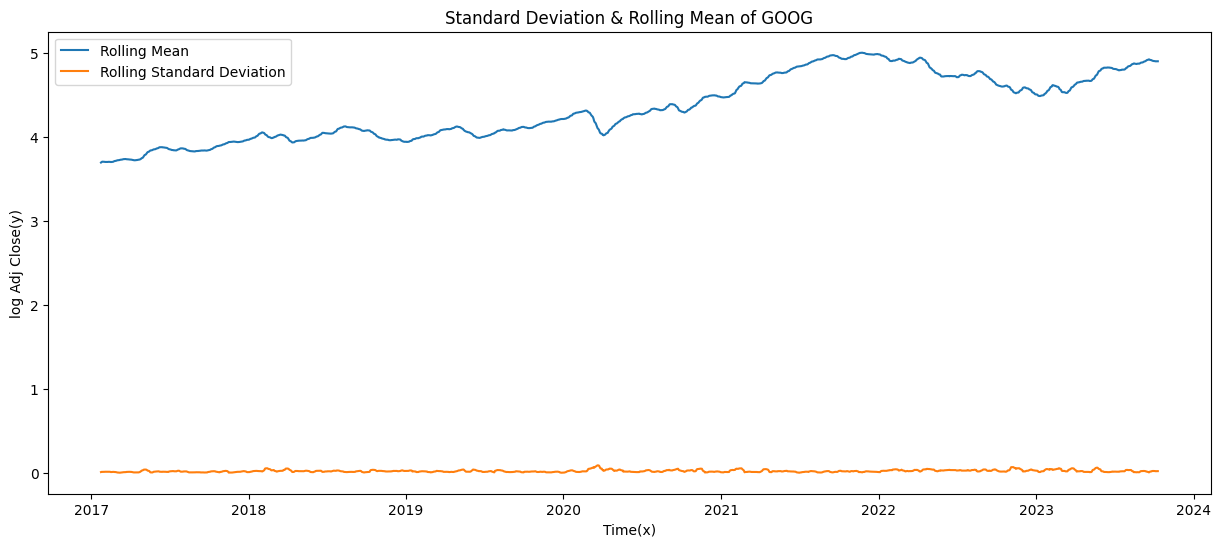

In [28]:
GOOG['log Adj Close'] = numpy.log(GOOG['Adj Close'])
log_avg_moving_GOOG = GOOG['log Adj Close'].rolling(15).mean()
std_log_GOOG = GOOG['log Adj Close'].rolling(15).std()

plot.figure(figsize = (15, 6))
plot.plot(GOOG['Date'], log_avg_moving_GOOG, label = "Rolling Mean")
plot.plot(GOOG['Date'], std_log_GOOG, label = "Rolling Standard Deviation")
plot.xlabel('Time(x)')
plot.ylabel('log Adj Close(y)')
plot.legend(loc = 'best')
plot.title("Standard Deviation & Rolling Mean of GOOG")

###Divide the data into training and test set

    Training Period: 2017-01-01 - 2023-06-30


---


    Testing Period:  2023-07-01 - 2023-10-10

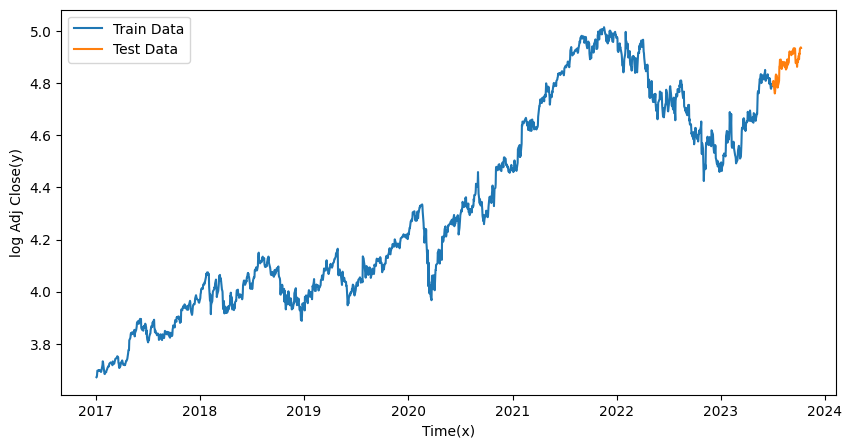

In [29]:
train_GOOG_data = GOOG[GOOG['Date'] < '2023-07-01']
test_GOOG_data = GOOG[GOOG['Date'] >= '2023-07-01'].reset_index(drop = True)

plot.figure(figsize = (10, 5))
plot.plot(train_GOOG_data['Date'], train_GOOG_data['log Adj Close'], label = 'Train Data')
plot.plot(test_GOOG_data['Date'], test_GOOG_data['log Adj Close'], label = 'Test Data')
plot.xlabel('Time(x)')
plot.ylabel('log Adj Close(y)')
plot.legend(loc = 'best')

In [30]:
auto_arima_model_GOOG = auto_arima(train_GOOG_data['log Adj Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(auto_arima_model_GOOG.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1634
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4188.471
Date:                Mon, 11 Dec 2023   AIC                          -8370.943
Time:                        18:56:41   BIC                          -8354.748
Sample:                             0   HQIC                         -8364.936
                               - 1634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      1.607      0.108      -0.000       0.002
ma.L1         -0.0850      0.017     -4.864      0.000      -0.119      -0.051
sigma2         0.0003   7.28e-06     47.590      0.0

In [31]:

arima_model_GOOG = sm.tsa.arima.ARIMA(train_GOOG_data['log Adj Close'], order = (5, 2, 1))
arima_model_fit_GOOG = arima_model_GOOG.fit()
print(arima_model_fit_GOOG.summary())

                               SARIMAX Results                                
Dep. Variable:          log Adj Close   No. Observations:                 1634
Model:                 ARIMA(5, 2, 1)   Log Likelihood                4176.344
Date:                Mon, 11 Dec 2023   AIC                          -8338.688
Time:                        18:56:44   BIC                          -8300.905
Sample:                             0   HQIC                         -8324.672
                               - 1634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0978      0.019     -5.125      0.000      -0.135      -0.060
ar.L2         -0.0107      0.020     -0.546      0.585      -0.049       0.028
ar.L3          0.0252      0.020      1.285      0.1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


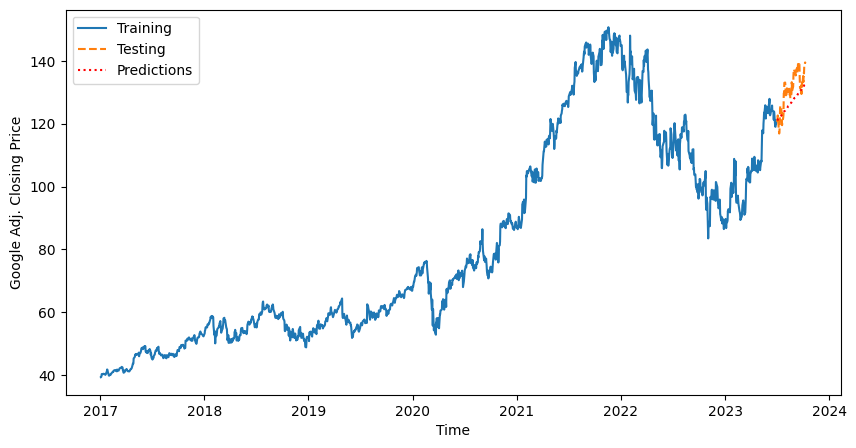

In [47]:
GOOG_output=arima_model_fit_GOOG.forecast(70, alpha=0.05)
# print("GOOG output: ",GOOG_output.shape)
GOOG_predictions = numpy.exp(GOOG_output)

plot.figure(figsize=(10, 5))
plot.plot(train_GOOG_data['Date'], train_GOOG_data['Adj Close'], label='Training')
plot.plot(test_GOOG_data['Date'], test_GOOG_data['Adj Close'], label='Testing', linestyle='--')

plot.plot(test_GOOG_data['Date'], GOOG_predictions, label='Predictions', color='red', linestyle=':')


plot.xlabel('Time')
plot.ylabel('Google Adj. Closing Price')
plot.legend()
GOOG_predictions = numpy.exp(GOOG_output.mean())

In [33]:
rmse = math.sqrt(mean_squared_error(test_GOOG_data['Adj Close'], [GOOG_predictions] * len(test_GOOG_data)))
mape = numpy.mean(numpy.abs(GOOG_predictions - test_GOOG_data['Adj Close'])/numpy.abs(test_GOOG_data['Adj Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 7.151197937579547
MAPE: 0.047934604234057855
